In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'

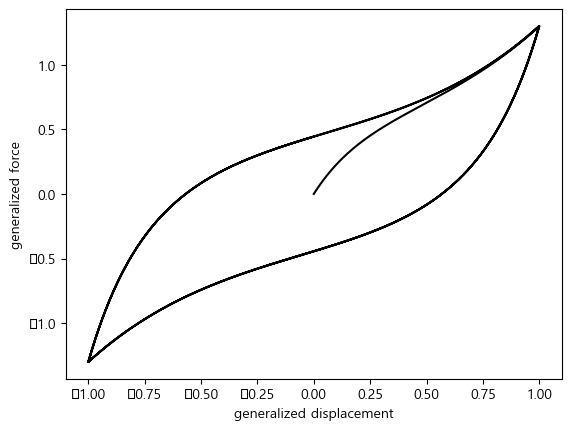

In [14]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()

In [17]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [18]:
total = pd.DataFrame()

In [19]:
total['u'] = u
total['time'] = t
total['f'] = f


In [20]:
total

,u,time,f
0,0.000000e+00,0.000,0.000000
1,6.283144e-03,0.001,0.017059
2,1.256604e-02,0.002,0.033687
3,1.884844e-02,0.003,0.049898
4,2.513010e-02,0.004,0.065705
...,...,...,...
2996,-2.513010e-02,2.996,0.430554
2997,-1.884844e-02,2.997,0.433910
2998,-1.256604e-02,2.998,0.437259
2999,-6.283144e-03,2.999,0.440601


In [21]:
x = total.iloc[:,0:2]
y = total.f

In [22]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

In [23]:
x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

----
## LSTM

In [24]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=(2, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 64)             16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [26]:
adam = optimizers.Adam(lr=0.01)

In [27]:
model.compile(loss = 'mse', optimizer = adam, metrics = 'mse')

In [28]:
history = model.fit(x_tr, y_tr, epochs = 500)

Epoch 1/500
63/63 [==============================] - 4s 2ms/step - loss: 0.1879 - mse: 0.1879
Epoch 2/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1386 - mse: 0.1386
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1214 - mse: 0.1214
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1105 - mse: 0.1105
Epoch 5/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1146 - mse: 0.1146
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1068 - mse: 0.1068
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1066 - mse: 0.1066
Epoch 8/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1025 - mse: 0.1025
Epoch 9/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1024 - mse: 0.1024
Epoch 10/500
63/63 [==============================] - 0s 3ms/step - loss: 0.1039 - mse: 0.1039
Epoch 11/500
63/63 [==============================] - 0s 3m

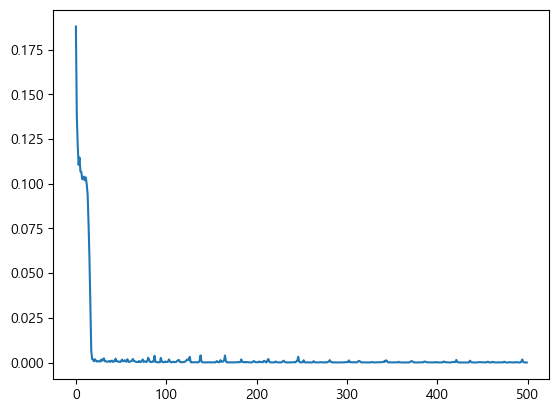

In [29]:
plt.plot(history.history['loss'])

In [30]:
pred = model.predict(x_te)

32/32 [==============================] - 1s 968us/step


In [31]:
pred = pred.reshape(-1,1)

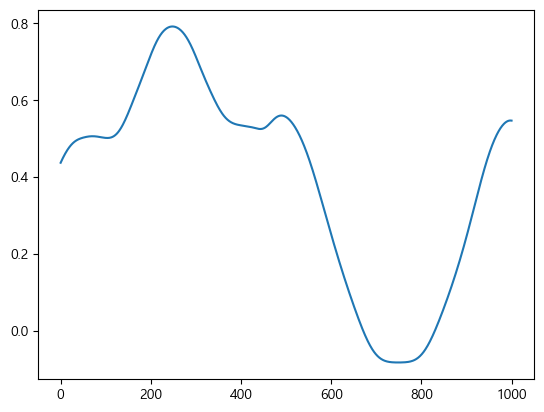

In [32]:
plt.plot(pred)

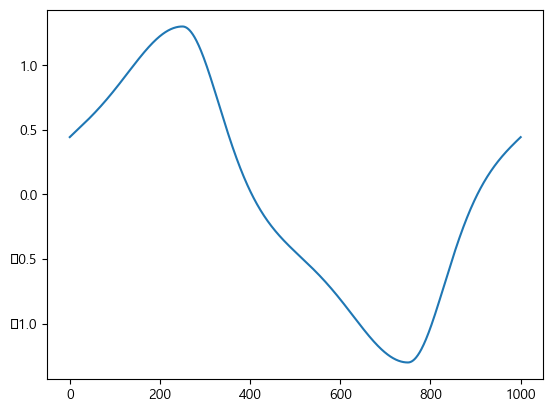

In [33]:
plt.plot(y_te)

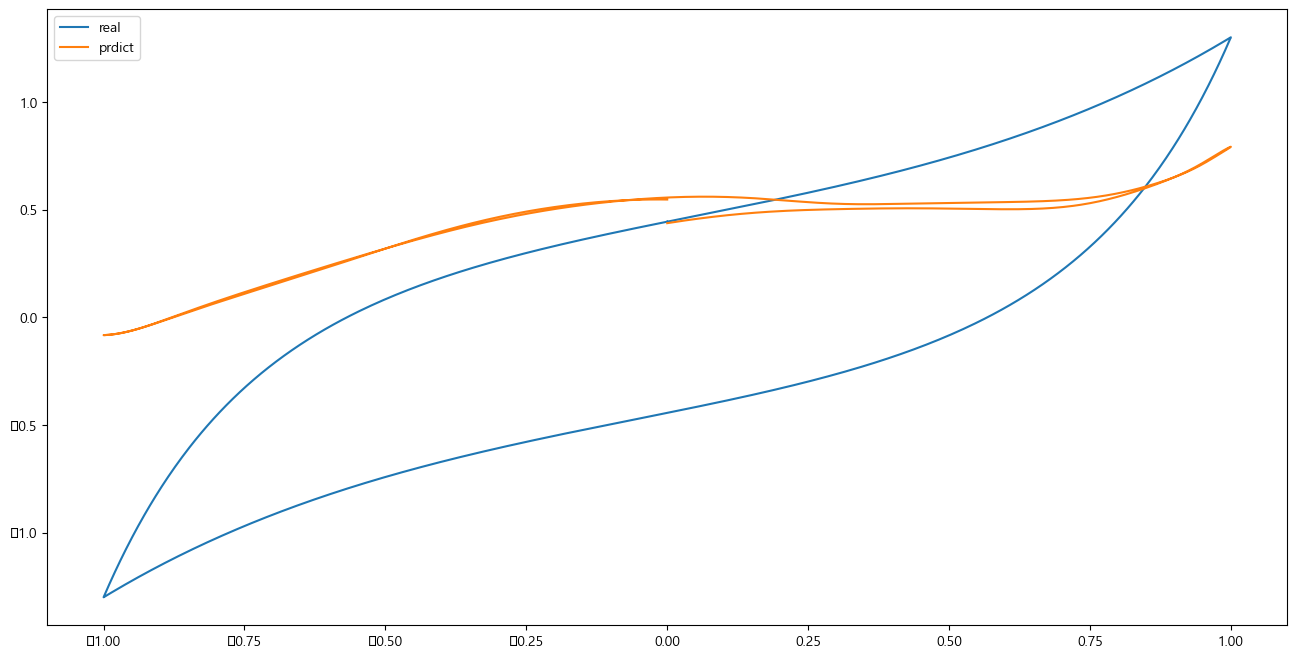

In [35]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred, label = 'prdict')
plt.legend()
plt.show()

----
## DNN

In [36]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(32, input_shape=(2,)))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(128, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = adam)

In [37]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                96        
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,849
Trainable params: 18,849
Non-trainable params: 0
_________________________________________________________________


In [38]:
dnn = model_2.fit(x_tr, y_tr, epochs=500)

Epoch 1/500
63/63 [==============================] - 0s 758us/step - loss: 0.7915
Epoch 2/500
63/63 [==============================] - 0s 742us/step - loss: 0.1267
Epoch 3/500
63/63 [==============================] - 0s 758us/step - loss: 0.1231
Epoch 4/500
63/63 [==============================] - 0s 758us/step - loss: 0.1113
Epoch 5/500
63/63 [==============================] - 0s 751us/step - loss: 0.1022
Epoch 6/500
63/63 [==============================] - 0s 774us/step - loss: 0.1015
Epoch 7/500
63/63 [==============================] - 0s 807us/step - loss: 0.1058
Epoch 8/500
63/63 [==============================] - 0s 758us/step - loss: 0.1018
Epoch 9/500
63/63 [==============================] - 0s 758us/step - loss: 0.1020
Epoch 10/500
63/63 [==============================] - 0s 790us/step - loss: 0.1036
Epoch 11/500
63/63 [==============================] - 0s 839us/step - loss: 0.1008
Epoch 12/500
63/63 [==============================] - 0s 800us/step - loss: 0.1038
Epoch 13/500


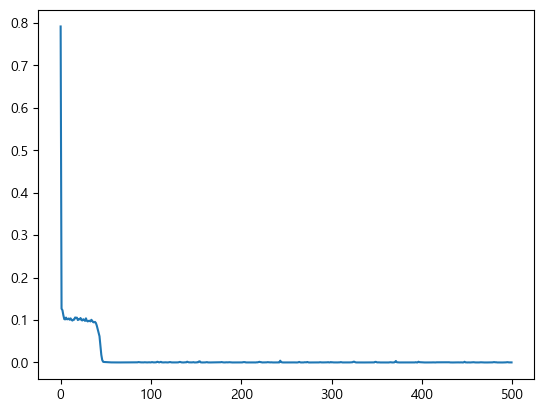

In [39]:
plt.plot(dnn.history['loss'])

In [40]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 613us/step


In [41]:
pred_2 = pred_2.reshape(-1,1)

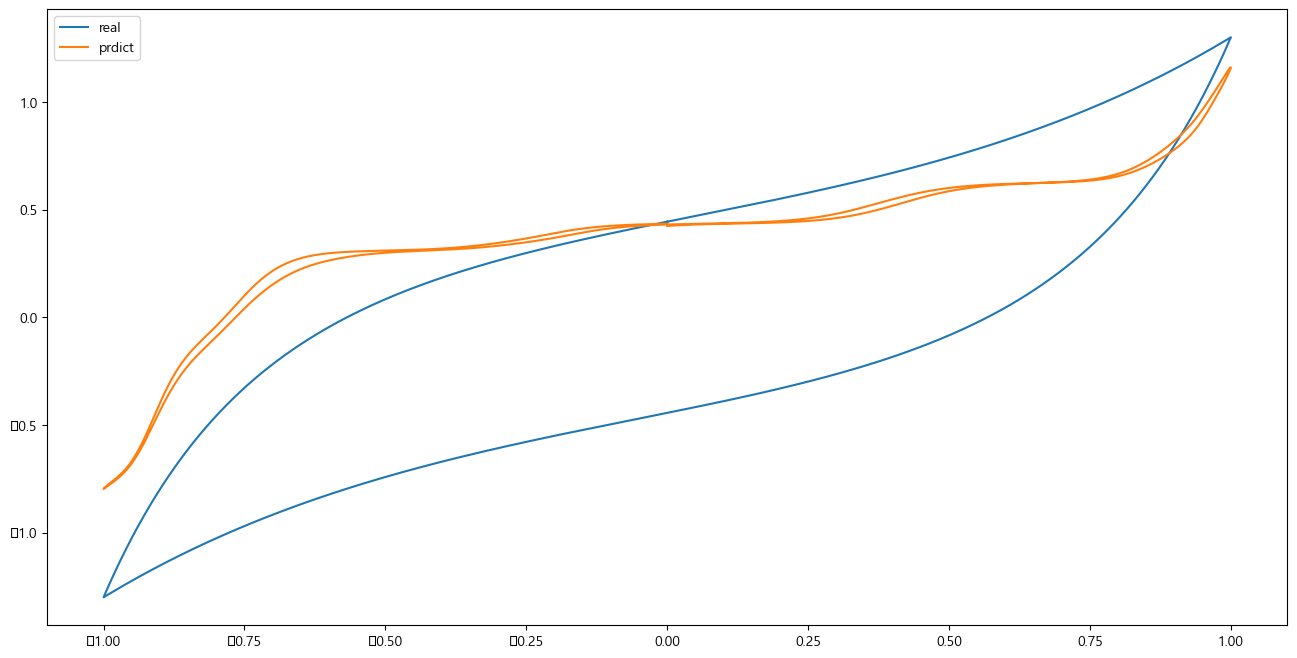

In [42]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred_2, label = 'prdict')
plt.legend()
plt.show()

---
## PINN

In [43]:
x0, y0 = 0, 0
w = 0.5
mu = 0.1

In [84]:
from scipy.integrate import odeint
from math import *
from tqdm import tqdm

In [45]:
def xt(x, t):
    return -2*beta*x[1] + np.exp(beta*x[1]) - np.exp(-beta*x[1]) + kb*x[1] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(x[1]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [49]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [50]:
model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

ephoch = 500

batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
dataset = dataset.batch(batch_size)

with tf.device('/GPU:0'):
    model = PINN(2, 1)

x_tr = tf.constant(x_tr, dtype=tf.float64)
y_tr = tf.constant(y_tr, dtype=tf.float64)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

for epoch in tqdm(range(ephoch)):
    for x_batch, y_batch in dataset:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            loss_value = loss_fn(y_batch, y_pred)
        
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [85]:
# # APPLIED DISPLACEMENT TIME HISTORY
# dt = 0.001
# t = np.arange(0, 3 + dt, dt)
# a0 = 1
# fr = 1
# u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
# v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
# n = len(u)

# uj_list = []

# # Set the four model parameters
# ka = 5.0
# kb = 0.5
# alfa = 5.0
# beta = 1.0

# # Compute the internal model parameters
# u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
# f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))

# # Initialize the generalized force vector
# f = np.zeros(n)

# # CALCULATIONS AT EACH TIME STEP
# for i in range(1, n):
#     # Update the history variable
#     uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
#     uj_list.append(uj)
#     # Evaluate the generalized force at time t
#     if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
#         f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
#     else:
#         f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

In [ ]:
import sympy as sp

f = -2*beta*u + sp.exp(beta*u) - sp.exp(-beta*u) + kb*u - sp.sign(v)*((ka-kb)/alfa)*(sp.exp(-alfa*(sp.sign(v)*(u-uj)+2*u0))-sp.exp(-2*alfa*u0)) + sp.sign(v)*f0


In [98]:
@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj):
    # Define the function inside the GradientTape context so that TensorFlow can track the operations on the tensor u
    with tf.GradientTape() as tape:
        tape.watch(u)  # Ensure that TensorFlow is tracking operations on u
        f = -2*beta*u + tf.exp(beta*u) - tf.exp(-beta*u) + kb*u - tf.sign(v)*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v)*(u-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v)*f0

    # Compute the gradient of f with respect to u
    df_du = tape.gradient(f, u)
    df_du = tf.cast(df_du, dtype=tf.float32)
    
    return df_du

In [107]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    u, v = tf.split(x_tr, 2, axis=-1)  # Assuming that x is passed as a function argument or is available in the scope

    # Define the physical loss as the difference between the predicted derivative and the computed derivative
    df_du = compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj)
    df_du = tf.expand_dims(df_du, axis=-1)
    physics_loss = tf.reduce_mean(tf.square(y_pred - df_du))

    # Define the data loss as the mean squared error
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss


In [108]:
batch_size = 32
epochs = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(x_tr, y_tr):
    with tf.GradientTape() as tape:
        y_pred = model(x_tr, training=True)  # Forward pass
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

# Now we can use this function in a training loop
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for start in range(0, len(x_tr), batch_size):
        end = start + batch_size
        x_batch = x_tr[start:end]
        y_batch = y_tr[start:end]
        loss_value = train_step(x_batch, y_batch)

        print('Training loss at step %s: %s' % (start, float(loss_value)))



Start of epoch 0
Training loss at step 0: 6.193304061889648
Training loss at step 32: 6.474438667297363
Training loss at step 64: 6.769858360290527
Training loss at step 96: 7.076380252838135
Training loss at step 128: 7.398453712463379
Training loss at step 160: 7.7052764892578125
Training loss at step 192: 7.937284469604492
Training loss at step 224: 8.027162551879883
Training loss at step 256: 7.81976318359375
Training loss at step 288: 7.2004852294921875
Training loss at step 320: 6.564018726348877
Training loss at step 352: 6.181344985961914
Training loss at step 384: 6.04113245010376
Training loss at step 416: 6.0483598709106445
Training loss at step 448: 6.13625431060791
Training loss at step 480: 6.2344560623168945
Training loss at step 512: 6.33372688293457
Training loss at step 544: 6.4394402503967285
Training loss at step 576: 6.605851650238037
Training loss at step 608: 6.844889163970947
Training loss at step 640: 7.134407997131348
Training loss at step 672: 7.421065330505

In [109]:
y_pred_pinn = model.predict(x_te)


32/32 [==============================] - 0s 549us/step


In [110]:
y_pred_pinn

array([[0.81447864, 0.8380156 ],
       [0.81274563, 0.8365689 ],
       [0.8110127 , 0.8351221 ],
       ...,
       [0.6804603 , 0.7348248 ],
       [0.67874753, 0.73335105],
       [0.6770348 , 0.73187727]], dtype=float32)

In [112]:
y_pred_pinn.shape

(1001, 2)

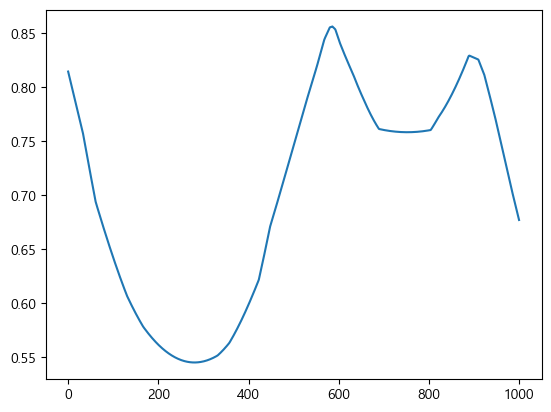

In [120]:
plt.plot(y_pred_pinn[:,0])

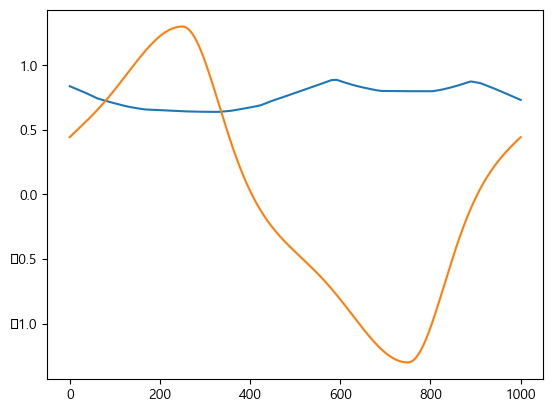

In [122]:
plt.plot(y_pred_pinn[:,1])
plt.plot(y_te)